## Model Training

This notebook deals with the pre-processing, feature engineering, and training of the ML model used in the GRAIN dataset workflow.

In [ ]:
import geopandas as gpd
import math
import numpy as np
import pandas as pd
import warnings
import os
import json
import traceback
import joblib
from core.get_sword_reach_id import get_sword_reach
from core.elevation_and_slope import compute_elevDiff_and_slope
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from shapely.ops import linemerge
from shapely.geometry import LineString

In [2]:
warnings.filterwarnings("ignore")

In [ ]:
#define data location paths and data formats
training_data = ['../assets/training_data/india_canals_training_set.parquet', '../assets/training_data/us_canals_training_set.parquet']
high_irrigation_countries_path = '../assets/irrigated_land_percentage/top_100_countries_sum.geojson'
osm_data_folder = '../assets/geofabrik_data'
sword_data_folder = '../assets/SWORD_v16_shp/shp'
sword_fileName_format = '{}_sword_reaches_hb{}_v16.shp'
hydrobasins_l2_folder = '../assets/HydroBasins_world_L2'
hydrobasins_l2_fileName_format = 'hybas_{}_lev02_v1c.shp'
world_countries_filePath = '../assets/supporting_data/world-administrative-boundaries.geojson'

sword_continent_map = '../assets/supporting_data/sword_continents.json'
dem_cog_fp = '../assets/dem_data/World_e-Atlas-UCSD_SRTM30-plus_v8.cog'

ml_training_data_save_fp = '../assets/outputs/ML_training_data'

In [4]:
def safe_sample(df, columns, n, label):
    while n > 0:
        try:
            return df[columns].sample(n=n, random_state=22)
        except ValueError:
            print(f"Not enough data in {label} for {n} samples, trying {n-50}")
            n -= 50
    print(f" Failed to sample any data from {label}")
    return df[columns].head(1).iloc[0:0] 

In [ ]:
#defining functions to compute the features
def vertex_per_length(geom):
    try:
        if geom.geom_type == 'LineString':
            num_vertices = len(geom.coords)
            length = geom.length
        elif geom.geom_type == 'MultiLineString':
            num_vertices = sum(len(part.coords) for part in geom.geoms)
            length = geom.length
        else:
            return np.nan  # for unsupported types

        return num_vertices / (length / 100) if length > 0 else np.nan

    except Exception:
        return np.nan


def get_straightness_ratio(geom):
    try:
        # Handle MultiLineString by combining all coordinates
        if geom.geom_type == 'MultiLineString':
            # print("MultiLineString")
            coords = [pt for line in geom.geoms for pt in line.coords]
            # print(coords)
        else:
            coords = list(geom.coords)

        if len(coords) > 3:
            start = coords[0]
            end = coords[-1]
            mid = coords[len(coords) // 2]

            # print(start, mid, end)

            dist1 = math.dist(start, mid)
            dist2 = math.dist(mid, end)
            simplified_length = dist1 + dist2
        else:
            start = coords[0]
            end = coords[1]
            simplified_length = math.dist(start, end)
        
        total_length = geom.length
        # print(total_length)
        sinousity = simplified_length / total_length # if total_length > 0 else np.nan
        
        # print("Simplified length:", simplified_length, "Total length:", total_length, "Sinousity:", sinousity)
        return sinousity

    except Exception as e:
        # print(f"Error: {e}")
        return np.nan


def mean_turning_angle(geom):
    def angle_at_b(a, b, c):
        ba = (a[0] - b[0], a[1] - b[1])
        bc = (c[0] - b[0], c[1] - b[1])
        dot = ba[0]*bc[0] + ba[1]*bc[1]
        det = ba[0]*bc[1] - ba[1]*bc[0]
        angle = math.atan2(abs(det), dot)
        return (180 - angle*180/math.pi)

    try:
        if geom.geom_type == "MultiLineString":
            coords = [pt for line in geom.geoms for pt in line.coords]
            coords = [coords[i] for i in range(len(coords)) if i == 0 or coords[i] != coords[i-1]]

        else:
            coords = list(geom.coords)

        if len(coords) < 3:
            return 0

        angles = [
            angle_at_b(coords[i - 1], coords[i], coords[i + 1])
            for i in range(1, len(coords) - 1)
        ]
        mean_turn_angle = np.mean(angles) if len(angles) > 0 else 0
        # print(mean_turn_angle)
        return mean_turn_angle
        
    except Exception:
        return np.nan


def get_curvature_index(geom):
    

    def angle_at_b(a, b, c):
        # Convert to vectors
        ba = (a[0] - b[0], a[1] - b[1])
        bc = (c[0] - b[0], c[1] - b[1])
        # Dot and cross products
        dot = ba[0]*bc[0] + ba[1]*bc[1]
        det = ba[0]*bc[1] - ba[1]*bc[0]

        # Angle in radians
        angle = math.atan2(abs(det), dot)
        # print(angle)
        return(180 - angle*180/math.pi)
        # return angle  # Always positive

    try:
        # Flatten coords
        if geom.geom_type == "MultiLineString":
            coords = [pt for line in geom.geoms for pt in line.coords]
            #removing duplicates
            coords = [coords[i] for i in range(len(coords)) if i == 0 or coords[i] != coords[i-1]]
            # print(coords)
            # print(len(coords))
            # print(type(coords))
        else:
            # print("LineString")
            coords = list(geom.coords)
            # print(coords)
            # print(type(coords))
        

        if len(coords) < 3:
            return 0

        angles = [
            angle_at_b(coords[i - 1], coords[i], coords[i + 1])
            for i in range(1, len(coords) - 1)
        ]
        # print(angles)
        total_angle_change = sum(angles)
        if geom.geom_type == 'LineString':
            num_vertices = len(geom.coords)
        elif geom.geom_type == 'MultiLineString':
            # num_vertices = sum(len(part.coords) for part in geom.geoms)
            num_vertices = len(coords)
            
        line_length_100m = geom.length / 100  # assuming EPSG:3857
        # print(line_length_100m)
        # return total_angle_change / (num_vertices-1)
        return total_angle_change / line_length_100m if line_length_100m > 0 else 0

    except Exception as e:
        print("Error: {}".format(e))
        traceback.print_exc()
        return np.nan



In [6]:
columns_to_keep = ["id", "geometry", "length", "waterway"]
canals_training_dataset = gpd.GeoDataFrame(columns=columns_to_keep, geometry="geometry", crs="EPSG:3857")
sword_rivers_osm_dataset = gpd.GeoDataFrame(columns=columns_to_keep, geometry="geometry", crs="EPSG:3857")

high_irrigation_countries = gpd.read_file(high_irrigation_countries_path)

#obtaining training canal data
for file in training_data:
    training_data_gpd = gpd.read_parquet(file)

    #select subset of 7000 random samples
    training_data_subset = training_data_gpd.sample(n=7000, random_state=42)
    training_data_subset['length'] = training_data_gpd['geometry'].length / 1E3
    if 'osm_id' in training_data_subset.columns:
        training_data_subset.rename(columns={'osm_id': 'id'}, inplace=True)
    #add to canals_training_dataset and make it into a geodataframe
    canals_training_dataset = pd.concat([canals_training_dataset, training_data_subset[columns_to_keep]])



In [ ]:
osm_data_folder = '../assets/osm_waterways/geoParquet/latest_record'
#get list of all parquet files
osm_parquet_files = [f for f in os.listdir(osm_data_folder) if f.endswith('.parquet')]


In [8]:
with open(sword_continent_map, 'r') as f:
    sword_continent_map = json.load(f)


In [9]:
global_osm_sword_sampled_rivers = gpd.GeoDataFrame(columns=columns_to_keep, geometry="geometry", crs="EPSG:3857")

columns_to_keep = ["id", "geometry", "length", "waterway"]
counter = 0
per_country_samples = 200
error_list = []
for file in tqdm(osm_parquet_files, total=len(osm_parquet_files), desc = "Processing OSM Country Scale Files:"):
    try:
        country_name = file.split('_final_dataset.parquet')[0]

        print(f'[{country_name}]')

        print("Reading OMS country scale or sub region scale file:")

        osm_data_gpd = gpd.read_parquet(os.path.join(osm_data_folder, file))
        osm_data_gpd = osm_data_gpd.to_crs(epsg=4326)
        
        if 'osm_id' in osm_data_gpd.columns:
            osm_data_gpd.rename(columns={'osm_id': 'id'}, inplace=True)
        #selecting a random canal and identifying sword reaches
        random_canal = osm_data_gpd.sample(n=1, random_state=42)

        sword_reach_id = get_sword_reach(random_canal)
        print(f'Sword Reach ID: {sword_reach_id}')
        # print(f'Sword File Path: {os.path.join(sword_data_folder,continent_abbrv,sword_fileName_format.format(continent_abbrv.lower(), sword_reach_id[0]))}')
    
        #loading sword files

        #logic to open all sword shapefiles and create a merged geodataframe
        sword_gdfs = []
        print("Loading Sword files and merging them if more than one exist:")
        for sword_id in sword_reach_id:

            for key, value in sword_continent_map.items():
                if str(sword_id) in value:
                    continent_abbrv = key

            sword_file_path = os.path.join(sword_data_folder,continent_abbrv,sword_fileName_format.format(continent_abbrv.lower(), sword_id))

            sword_data_gpd = gpd.read_file(sword_file_path)
            sword_gdfs.append(sword_data_gpd)

        sword_data_gpd = pd.concat(sword_gdfs)

        osm_rivers = osm_data_gpd[osm_data_gpd['waterway'].isin(['river'])]
        osm_rivers_mercator = osm_rivers.to_crs(epsg=3857)

        country_sword_mercator = sword_data_gpd.to_crs(epsg=3857)


        osm_rivers_sword = gpd.sjoin(osm_rivers_mercator, country_sword_mercator, how="inner", predicate="intersects")

        #computing features
        print("[[{}]]Computing features:".format(country_name))
        print("Length...")
        osm_rivers_sword['length'] = osm_rivers_sword.geometry.length/1E3
        print("Straightness ratio...")
        osm_rivers_sword['straightness_ratio'] = osm_rivers_sword['geometry'].apply(get_straightness_ratio)
        print("Average curvature per 100m...")
        osm_rivers_sword['average_curvature_per_100m'] = osm_rivers_sword['geometry'].apply(get_average_curvature_per_100m)
        #dropiing na values
        # osm_rivers_sword = osm_rivers_sword.dropna()
        
        print("Combined curvature straightness score...")
        osm_rivers_sword['combined_curvature_straightness_score'] = 10*osm_rivers_sword['straightness_ratio'] - osm_rivers_sword['average_curvature_per_100m']
        print("elevation difference and slope...")
        osm_rivers_sword = osm_rivers_sword[(osm_rivers_sword['combined_curvature_straightness_score'] < 6) &(osm_rivers_sword['length'] > 5) &(osm_rivers_sword['length'] < 200)]
        # osm_rivers_sword = compute_elevDiff_and_slope(dem_cog_fp, osm_rivers_sword)  

        #sampling osm rivers matching with sword rivers to form part of training dataset
        osm_rivers_sword_sample = safe_sample(osm_rivers_sword, columns_to_keep, per_country_samples, "osm_rivers_sword")
        osm_rivers_sword_sample = osm_rivers_sword_sample.to_crs(epsg=3857)
        #adding to global training dataset
        global_osm_sword_sampled_rivers = pd.concat([global_osm_sword_sampled_rivers, osm_rivers_sword_sample], ignore_index=True)
        print(f"Added {len(osm_rivers_sword_sample)} samples to global training dataset")
    except Exception as e:
        print(f"Error processing {file}: {str(e)} \n")
        error_list.append(f"Error processing {file}: {str(e)}")
        traceback.print_exc()
        continue
    else:
        counter += 1
        print(f"Completed {country_name}\n")
    
print(f"Completed {counter} countries out of {len(osm_parquet_files)} with errors: {error_list}")
    

Processing OSM Country Scale Files::   0%|          | 0/115 [00:00<?, ?it/s]

[cambodia_waterway.parquet]
Reading OMS country scale or sub region scale file:
Country detected: ['Cambodia', 'Vietnam']
Number of level 2 hydrobasins in Cambodia: 1
PFAF_IDs: [44]
returning pfaf ids as sword reach ids
Sword Reach ID: [44]
Loading Sword files and merging them if more than one exist:


Traceback (most recent call last):
  File "/tmp/ipykernel_1203953/303829341.py", line 60, in <module>
    osm_rivers_sword['average_curvature_per_100m'] = osm_rivers_sword['geometry'].apply(get_average_curvature_per_100m)
                                                                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'get_average_curvature_per_100m' is not defined
Processing OSM Country Scale Files::   1%|          | 1/115 [00:01<02:54,  1.53s/it]

[[cambodia_waterway.parquet]]Computing features:
Length...
Straightness ratio...
Average curvature per 100m...
Error processing cambodia_waterway.parquet: name 'get_average_curvature_per_100m' is not defined 

[scotland_waterway.parquet]
Reading OMS country scale or sub region scale file:
Country detected: ['U.K. of Great Britain and Northern Ireland']
Number of level 2 hydrobasins in U.K. of Great Britain and Northern Ireland: 1
PFAF_IDs: [23]
returning pfaf ids as sword reach ids
Sword Reach ID: [23]
Loading Sword files and merging them if more than one exist:


Traceback (most recent call last):
  File "/tmp/ipykernel_1203953/303829341.py", line 60, in <module>
    osm_rivers_sword['average_curvature_per_100m'] = osm_rivers_sword['geometry'].apply(get_average_curvature_per_100m)
                                                                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'get_average_curvature_per_100m' is not defined
Processing OSM Country Scale Files::   2%|▏         | 2/115 [00:03<02:59,  1.59s/it]

[[scotland_waterway.parquet]]Computing features:
Length...
Straightness ratio...
Average curvature per 100m...
Error processing scotland_waterway.parquet: name 'get_average_curvature_per_100m' is not defined 

[central-fed-district_waterway.parquet]
Reading OMS country scale or sub region scale file:
Country detected: ['Russian Federation']
Number of level 2 hydrobasins in Russian Federation: 14
PFAF_IDs: [35, 42, 41, 46, 22, 24, 25, 26, 28, 31, 32, 33, 34, 36]
returning pfaf ids as sword reach ids
Sword Reach ID: [35, 42, 41, 46, 22, 24, 25, 26, 28, 31, 32, 33, 34, 36]
Loading Sword files and merging them if more than one exist:
[[central-fed-district_waterway.parquet]]Computing features:
Length...
Straightness ratio...


Traceback (most recent call last):
  File "/tmp/ipykernel_1203953/303829341.py", line 60, in <module>
    osm_rivers_sword['average_curvature_per_100m'] = osm_rivers_sword['geometry'].apply(get_average_curvature_per_100m)
                                                                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'get_average_curvature_per_100m' is not defined
Processing OSM Country Scale Files::   3%|▎         | 3/115 [00:12<09:11,  4.93s/it]

Average curvature per 100m...
Error processing central-fed-district_waterway.parquet: name 'get_average_curvature_per_100m' is not defined 

[north-korea_waterway.parquet]
Reading OMS country scale or sub region scale file:
Country detected: ["Democratic People's Republic of Korea"]
Number of level 2 hydrobasins in Democratic People's Republic of Korea: 1
PFAF_IDs: [42]
returning pfaf ids as sword reach ids
Sword Reach ID: [42]
Loading Sword files and merging them if more than one exist:


Traceback (most recent call last):
  File "/tmp/ipykernel_1203953/303829341.py", line 60, in <module>
    osm_rivers_sword['average_curvature_per_100m'] = osm_rivers_sword['geometry'].apply(get_average_curvature_per_100m)
                                                                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'get_average_curvature_per_100m' is not defined
Processing OSM Country Scale Files::   3%|▎         | 4/115 [00:13<06:49,  3.69s/it]

[[north-korea_waterway.parquet]]Computing features:
Length...
Straightness ratio...
Average curvature per 100m...
Error processing north-korea_waterway.parquet: name 'get_average_curvature_per_100m' is not defined 

[australia_waterway copy.parquet]
Reading OMS country scale or sub region scale file:
Country detected: ['Australia']
Number of level 2 hydrobasins in Australia: 2
PFAF_IDs: [56, 57]
returning pfaf ids as sword reach ids
Sword Reach ID: [56, 57]
Loading Sword files and merging them if more than one exist:


Processing OSM Country Scale Files::   3%|▎         | 4/115 [00:19<08:56,  4.83s/it]


KeyboardInterrupt: 

In [ ]:
global_osm_sword_sampled_rivers.to_file(ml_training_data_save_fp + '/global_osm_sword_sampled_rivers.geojson', driver='GeoJSON')


In [ ]:
columns_to_keep = ["id", "geometry", "length", "waterway"]
global_osm_sampled_canals_man_made = gpd.GeoDataFrame(columns=columns_to_keep, geometry="geometry", crs="EPSG:3857")
sample_num = 6000
for file in training_data:
    training_data_gpd = gpd.read_parquet(file)
    if 'osm_id' in training_data_gpd.columns:
        training_data_gpd.rename(columns={'osm_id': 'id'}, inplace=True)
    #select subset of 7000 random samples
    training_data_subset = training_data_gpd.sample(n=sample_num, random_state=42)
    training_data_subset['length'] = training_data_gpd['geometry'].length / 1E3
    
    global_osm_sampled_canals_man_made = pd.concat([global_osm_sampled_canals_man_made, training_data_subset[columns_to_keep]])


global_osm_sampled_canals_man_made['waterway'] = 'canal'
 

In [ ]:
global_osm_sampled_canals_man_made.to_file(ml_training_data_save_fp + '/global_osm_sampled_canals_man_made.geojson', driver='GeoJSON')

In [ ]:
ML_training_data = pd.concat([global_osm_sword_sampled_rivers, global_osm_sampled_canals_man_made], ignore_index=True)


In [ ]:
ML_training_data.to_file(ml_training_data_save_fp + '/ML_training_data_v1.geojson', driver='GeoJSON')

### Feature Engineering

In [ ]:
#loading ML training data
version = 'v1'
ML_training_data = gpd.read_file(f'../assets/outputs/ML_training_data/ML_training_data_{version}.geojson')
ML_training_data = ML_training_data.to_crs(epsg=3857)

In [ ]:
ML_training_data['num_vertex_per_100m'] = ML_training_data['geometry'].apply(vertex_per_length)
ML_training_data['straightness_ratio'] = ML_training_data['geometry'].apply(get_straightness_ratio)
ML_training_data['curvature_index_per_100m'] = ML_training_data['geometry'].apply(get_curvature_index)

ML_training_data['mean_turning_angle'] = ML_training_data['geometry'].apply(mean_turning_angle)

# ML_training_data['mean_turning_angle'] = ML_training_data['geometry'].apply(mean_turning_angle)
ML_training_data = compute_elevDiff_and_slope(dem_cog_fp, ML_training_data)
ML_training_data["label"] = ML_training_data["waterway"]
#save to disk as csv
# feature_cols = ["straightness_ratio", "mean_turning_angle", "vertex_per_length", 'length', 'label']
feature_cols = ["straightness_ratio",'num_vertex_per_100m','mean_turning_angle','curvature_index_per_100m', 'length','start_el', 'end_el','elev_diff','slope', 'label']
ML_featureEngineered_data = ML_training_data[feature_cols]
ML_featureEngineered_data.dropna(inplace=True)
ML_featureEngineered_data.to_csv(ml_training_data_save_fp + f'/ML_featureEngineered_data_{version}.csv', index=False)


Computing slopes: 100%|██████████| 24200/24200 [00:14<00:00, 1614.07it/s]


Errors in slope computation: 0


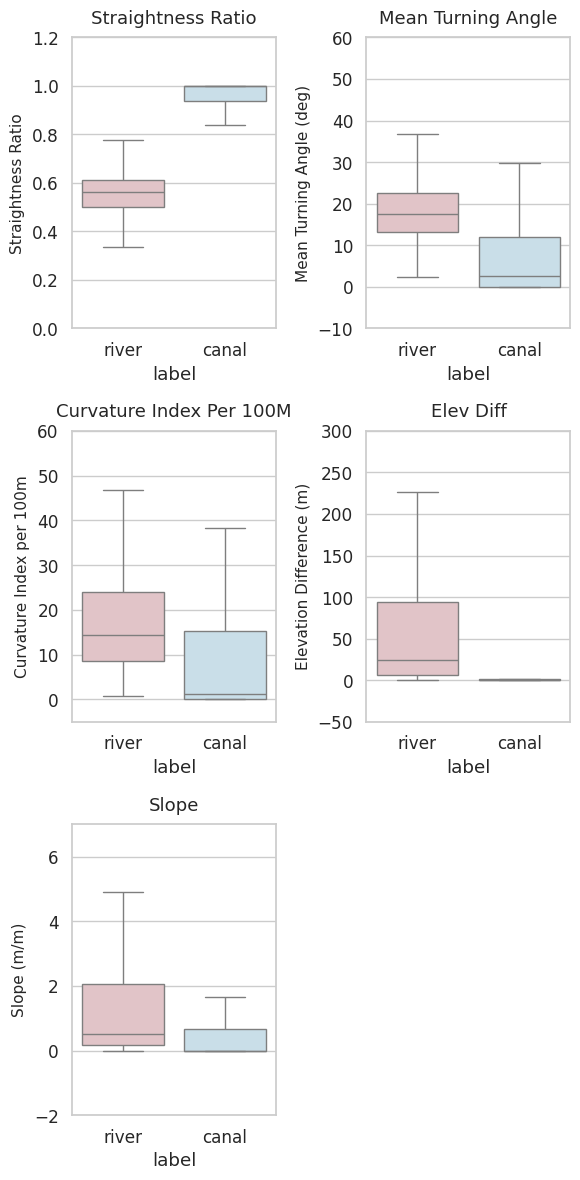

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

features = [
    "straightness_ratio", "mean_turning_angle",
    "curvature_index_per_100m", "elev_diff", "slope"
]

ylims = {
    "straightness_ratio": (0.0, 1.2),
    "mean_turning_angle": (-10, 60),
    "curvature_index_per_100m": (-5, 60),
    "elev_diff": (-50, 300),
    "slope": (-2, 7)
}

ylabels = [
    "Straightness Ratio", "Mean Turning Angle (deg)",
    "Curvature Index per 100m", "Elevation Difference (m)", "Slope (m/m)"
]

n_features = len(features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.boxplot(
        x="label", y=feature,
        data=ML_featureEngineered_data,
        palette={"river": "#E6BFC5", "canal": "#C4E0ED"},
        showfliers=False,
        ax=ax
        boxprops=dict(edgecolor='black', linewidth=1.5),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        medianprops=dict(color='darkred', linewidth=1.5)
    )
    
    ax.set_title(f"{feature.replace('_', ' ').title()}", fontsize=13, pad=10)
    # ax.set_xlabel("Class", fontsize=11)
    ax.set_ylabel(ylabels[i], fontsize=11, labelpad=5)
    
    if feature in ylims:
        ax.set_ylim(*ylims[feature])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


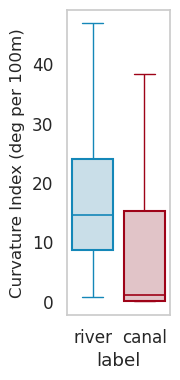

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
# features = [
#     "straightness_ratio", "mean_turning_angle",
#     "curvature_index_per_100m", "elev_diff", "slope"
# ]


fill_palette = {"river": "#C4E0ED", "canal": "#E6BFC5"}
edge_palette = {"river": "#1487b8", "canal": "#9e0318"}
median_palette = {"river": "#1487b8", "canal": "#9e0318"}

fig, ax = plt.subplots(figsize=(2, 4))

for label in ["river", "canal"]:
    sns.boxplot(
        x="label", y="curvature_index_per_100m",
        data=ML_featureEngineered_data[ML_featureEngineered_data["label"] == label],
        palette={label: fill_palette[label]},
        boxprops=dict(edgecolor=edge_palette[label], linewidth=1.5),
        whiskerprops=dict(color=edge_palette[label], linewidth=1),
        capprops=dict(color=edge_palette[label], linewidth=1),
        medianprops=dict(color=median_palette[label], linewidth=1.2),
        showfliers=False,
        ax=ax
    )

# Set y-axis label and move it to the right
ax.set_ylabel("Curvature Index (deg per 100m)", fontsize=12, labelpad=5)
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position('right')
ax.grid(False)

plt.tight_layout()
plt.show()



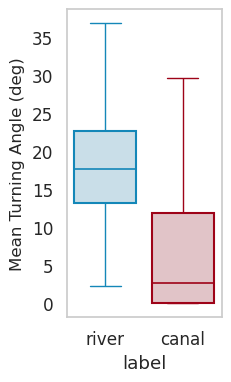

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example colors
fill_palette = {"river": "#C4E0ED", "canal": "#E6BFC5"}
edge_palette = {"river": "#1487b8", "canal": "#9e0318"}
median_palette = {"river": "#1487b8", "canal": "#9e0318"}

fig, ax = plt.subplots(figsize=(2, 4))

for label in ["river", "canal"]:
    sns.boxplot(
        x="label", y="mean_turning_angle",   # replace with your feature
        data=ML_featureEngineered_data[ML_featureEngineered_data["label"] == label],
        palette={label: fill_palette[label]},
        boxprops=dict(edgecolor=edge_palette[label], linewidth=1.5),
        whiskerprops=dict(color=edge_palette[label], linewidth=1),
        capprops=dict(color=edge_palette[label], linewidth=1),
        medianprops=dict(color=median_palette[label], linewidth=1.2),
        showfliers=False,
        ax=ax
    )
ax.set_ylabel("Mean Turning Angle (deg)", fontsize=12, labelpad=5)
ax.grid(False)



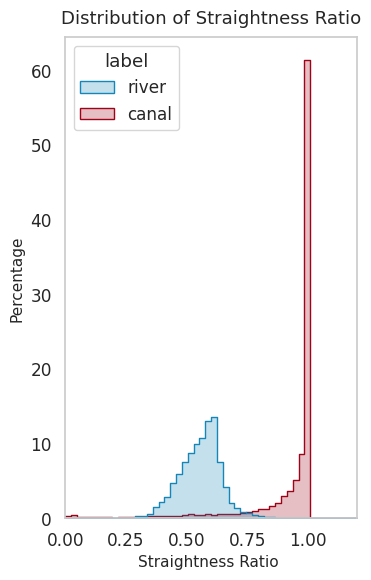

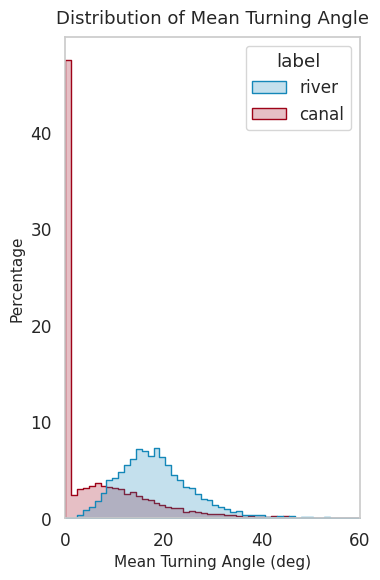

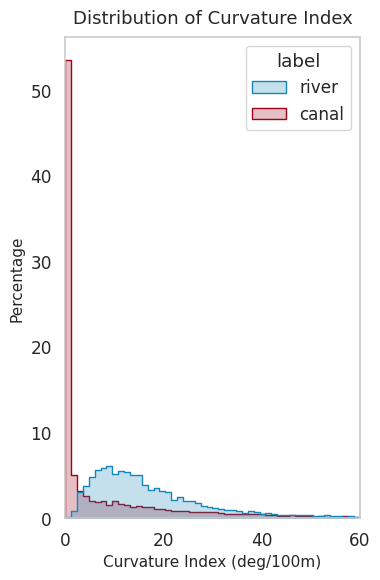

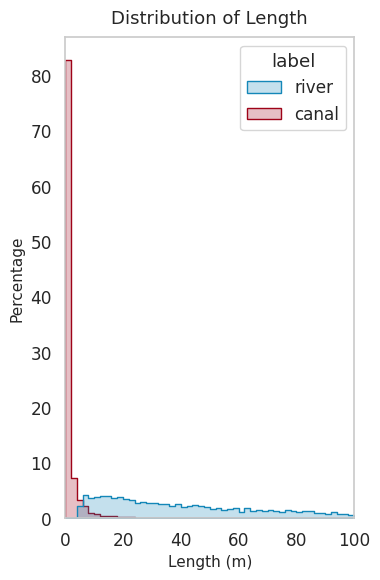

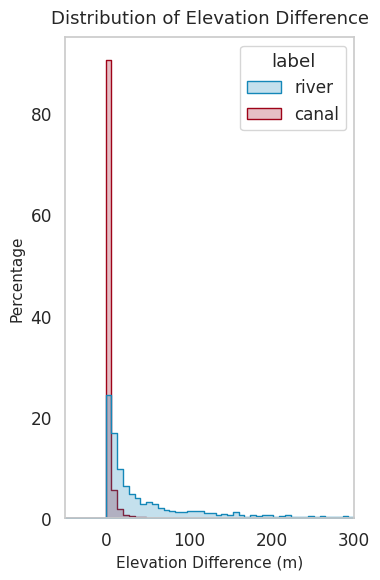

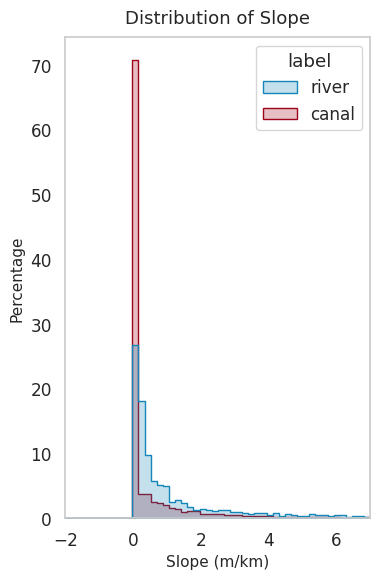

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

features = [
    "straightness_ratio", "mean_turning_angle",
    "curvature_index_per_100m", "length", "elev_diff", "slope"
]

xlims = {
    "straightness_ratio": (0.0, 1.2),
    "mean_turning_angle": (0, 60),                # degrees
    "curvature_index_per_100m": (0, 60),
    "length": (0, 100),                           # metres
    "elev_diff": (-50, 300),                      # metres
    "slope": (-2, 7)                              # m / m
}

titles = {
    "straightness_ratio": "Straightness Ratio ",
    "mean_turning_angle": "Mean Turning Angle (deg)",
    "curvature_index_per_100m": "Curvature Index (deg/100m)",
    "length": "Length (m)",
    "elev_diff": "Elevation Difference (m)",
    "slope": "Slope (m/km)"
}

palette_dict = {
    "river": "#1487b8",
    "canal": "#9e0318"
}

for feature in features:
    fig, ax = plt.subplots(figsize=(4, 6))

    sns.histplot(
        data=ML_featureEngineered_data,
        x=feature,
        hue="label",
        hue_order=["river", "canal"],
        palette=palette_dict,
        kde=False,
        element="step",
        stat="percent",
        bins=50,
        common_norm=False,
        binrange=xlims.get(feature)
    )

    ax.set_xlim(xlims.get(feature))
    ax.set_title(f"Distribution of {titles[feature].split('(')[0][:-1]}", fontsize=13, pad=10)
    ax.set_xlabel(titles[feature], fontsize=11)
    ax.set_ylabel("Percentage", fontsize=11)

    plt.grid(False)
    plt.tight_layout()
    plt.show()


## ML Classification using Random Forest

In [71]:
import pandas as pd

# Randomly sample 10,000 rows for each class
canals_sampled = ML_featureEngineered_data[ML_featureEngineered_data["label"] == "canal"].sample(n=10000, random_state=42)
rivers_sampled = ML_featureEngineered_data[ML_featureEngineered_data["label"] == "river"].sample(n=10000, random_state=42)

# Concatenate the sampled datasets
ml_balanced_df = pd.concat([canals_sampled, rivers_sampled]).reset_index(drop=True)


In [ ]:
model_save_path = '../assets/outputs/ML_training_data/ML_model_random_forest_v2_20ksamples.pkl'
feature_cols = ['elev_diff','straightness_ratio','curvature_index_per_100m','mean_turning_angle','slope']
X = ml_balanced_df[feature_cols].copy()
y = ml_balanced_df["label"].map({"river": 0, "canal": 1})

#creating train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#creating and training random forest classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

#predicting on test set
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))


joblib.dump(model, model_save_path)
print(f"Model saved to {model_save_path}")

0.989
Model saved to /water3/saraths/Research_Files/GRAIN/assets/outputs/ML_training_data/ML_model_random_forest_v2_20ksamples.pkl


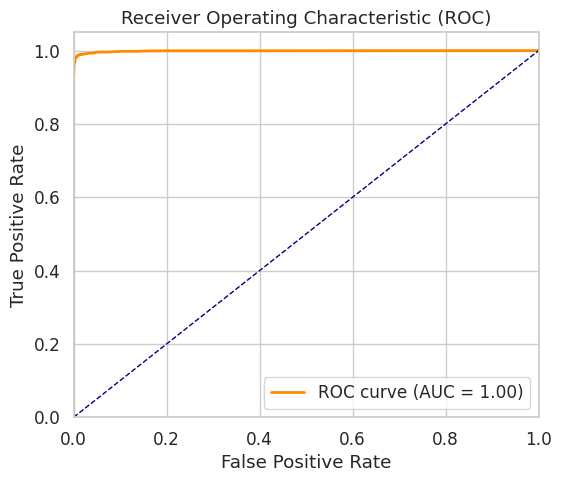

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume model is already trained and you have:
# X_test, y_test (binary labels: 0 = river, 1 = canal)

# Get predicted probabilities for class 1 (canal)
y_score = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Define model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate using cross_val_score
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean Accuracy: %.3f ± %.3f" % (scores.mean(), scores.std()))


Cross-validation accuracies: [0.9865 0.9825 0.9835 0.984  0.9895 0.9875 0.9855 0.988  0.9885 0.988 ]
Mean Accuracy: 0.986 ± 0.002


In [129]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Define the classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Prepare data
X = ml_balanced_df[feature_cols]
y = ml_balanced_df["label"].map({"river": 0, "canal": 1})

# Define scorers
precision = cross_val_score(model, X, y, cv=10, scoring=make_scorer(precision_score))
recall    = cross_val_score(model, X, y, cv=10, scoring=make_scorer(recall_score))
f1        = cross_val_score(model, X, y, cv=10, scoring=make_scorer(f1_score))

# Print results
print(f"Precision: {precision.mean():.3f} ± {precision.std():.3f}")
print(f"Recall:    {recall.mean():.3f} ± {recall.std():.3f}")
print(f"F1 Score:  {f1.mean():.3f} ± {f1.std():.3f}")


Precision: 0.992 ± 0.003
Recall:    0.980 ± 0.004
F1 Score:  0.986 ± 0.003


In [111]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X, y, cv=skf)

# Confusion matrix
cm = confusion_matrix(y, y_pred_cv)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y, y_pred_cv, target_names=["river", "canal"]))


Confusion Matrix:
 [[9918   82]
 [ 191 9809]]
              precision    recall  f1-score   support

       river       0.98      0.99      0.99     10000
       canal       0.99      0.98      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [112]:
scores

array([0.9865, 0.9825, 0.9835, 0.984 , 0.9895, 0.9875, 0.9855, 0.988 ,
       0.9885, 0.988 ])

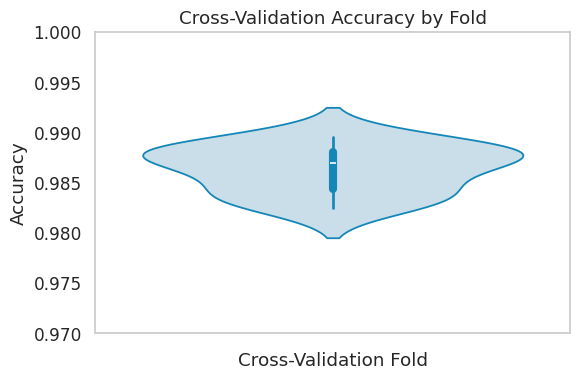

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# fill_palette = {"river": "#C4E0ED", "canal": "#E6BFC5"}
# edge_palette = {"river": "#1487b8", "canal": "#9e0318"}
# median_palette = {"river": "#1487b8", "canal": "#9e0318"}

# Step 1: Create a dataframe from the scores
df_scores = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(scores))],
    "Accuracy": scores
})

# Step 2: Plot using seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(y=scores, inner="box", linewidth=1.3, color="#C4E0ED", linecolor="#1487b8")

    
plt.ylim(0.97, 1.0)  # adjust as needed
plt.title("Cross-Validation Accuracy by Fold")
plt.ylabel("Accuracy")
plt.xlabel("Cross-Validation Fold")
plt.tight_layout()
plt.grid(False)
plt.show()


                precision    recall  f1-score   support

         River       0.98      0.99      0.99      2000
Canal_man_made       0.99      0.98      0.99      2000

      accuracy                           0.99      4000
     macro avg       0.99      0.99      0.99      4000
  weighted avg       0.99      0.99      0.99      4000



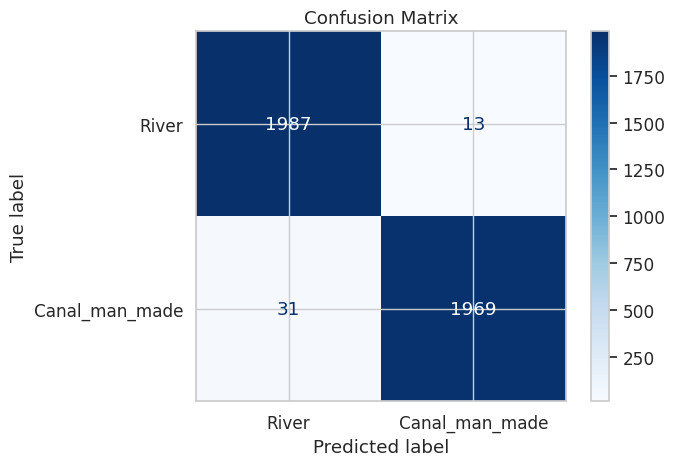

In [108]:
## evaluating performance
# Print classification metrics
print(classification_report(y_test, y_pred, target_names=["River", "Canal_man_made"]))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["River", "Canal_man_made"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

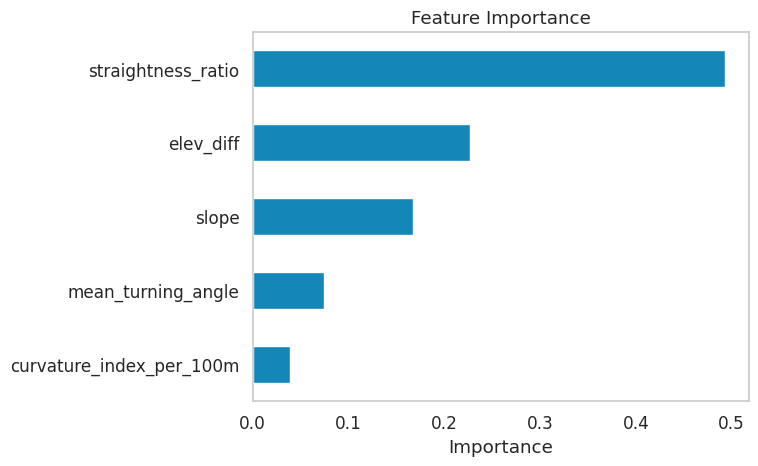

In [109]:
feature_importance = pd.Series(model.feature_importances_, index=feature_cols)
feature_importance.sort_values().plot(kind="barh", title="Feature Importance", color = "#1487b8")
plt.xlabel("Importance")
plt.grid(False)
plt.show()


### Validation on Teesta

In [ ]:
teesta_fp = "../assets/outputs/test_outputs/osm_teesta_waterways.geojson"
teesta_gdf = gpd.read_file(teesta_fp)

#converting to mercator
teesta_gdf = teesta_gdf.to_crs(epsg=3857)
teesta_gdf = teesta_gdf[teesta_gdf['geometry'].geom_type.isin(['LineString', 'MultiLineString'])]
# Preview
# #filter out canals, diteches, and drains as one dataset and all others as rivers. Use ~in for the second
teesta_gdf_canals = teesta_gdf[teesta_gdf['waterway'].isin(['canal', 'ditch', 'drain'])]
teesta_gdf_rivers = teesta_gdf[~teesta_gdf['waterway'].isin(['canal', 'ditch', 'drain'])]


In [177]:
#extract only geometry, waterway columns for general gdf, canals, and rivers
#drop all rows that are not linestring or multilinestring

teesta_gdf = teesta_gdf[["geometry", "waterway"]]
teesta_gdf = teesta_gdf.rename(columns={"waterway": "osm_label"})

teesta_gdf_canals = teesta_gdf_canals[["geometry", "waterway"]]
teesta_gdf_canals = teesta_gdf_canals.rename(columns={"waterway": "osm_label"})

teesta_gdf_rivers = teesta_gdf_rivers[["geometry", "waterway"]]
teesta_gdf_rivers = teesta_gdf_rivers.rename(columns={"waterway": "osm_label"})

#computing features
teesta_gdf["straightness_ratio"] = teesta_gdf.geometry.apply(get_straightness_ratio)
teesta_gdf["curvature_index_per_100m"] = teesta_gdf.geometry.apply(get_curvature_index)
teesta_gdf["mean_turning_angle"] = teesta_gdf.geometry.apply(mean_turning_angle)

# # #compute length of the geometry in km
teesta_gdf['length'] = teesta_gdf['geometry'].length / 1E3
teesta_gdf = compute_elevDiff_and_slope(dem_cog_fp,teesta_gdf)

# #drop nans
teesta_gdf = teesta_gdf.dropna()

# do the same for canal and river separately
teesta_gdf_rivers["straightness_ratio"] = teesta_gdf_rivers.geometry.apply(get_straightness_ratio)
teesta_gdf_rivers["curvature_index_per_100m"] = teesta_gdf_rivers.geometry.apply(get_curvature_index)
teesta_gdf_rivers["mean_turning_angle"] = teesta_gdf_rivers.geometry.apply(mean_turning_angle)

# # #compute length of the geometry in km
teesta_gdf_rivers['length'] = teesta_gdf_rivers['geometry'].length / 1E3
teesta_gdf_rivers = compute_elevDiff_and_slope(dem_cog_fp,teesta_gdf_rivers)
teesta_gdf_rivers = teesta_gdf_rivers.dropna()

#
teesta_gdf_canals["straightness_ratio"] = teesta_gdf_canals.geometry.apply(get_straightness_ratio)
teesta_gdf_canals["curvature_index_per_100m"] = teesta_gdf_canals.geometry.apply(get_curvature_index)
teesta_gdf_canals["mean_turning_angle"] = teesta_gdf_canals.geometry.apply(mean_turning_angle)

teesta_gdf_canals['length'] = teesta_gdf_canals['geometry'].length / 1E3
teesta_gdf_canals = compute_elevDiff_and_slope(dem_cog_fp,teesta_gdf_canals)
teesta_gdf_canals = teesta_gdf_canals.dropna()

Computing slopes: 100%|██████████| 1703/1703 [00:02<00:00, 747.49it/s]


Errors in slope computation: 0


Computing slopes: 100%|██████████| 609/609 [00:01<00:00, 465.09it/s]


Errors in slope computation: 0


Computing slopes: 100%|██████████| 1094/1094 [00:00<00:00, 1143.93it/s]

Errors in slope computation: 0


In [178]:
X_teesta = teesta_gdf[feature_cols].dropna()
teesta_gdf["predicted_label"] = model.predict(X_teesta)
teesta_gdf["predicted_class"] = teesta_gdf["predicted_label"].map({0: "river", 1: "canal"})

#same for river and canals
X_teesta_rivers = teesta_gdf_rivers[feature_cols].dropna()
teesta_gdf_rivers["predicted_label"] = model.predict(X_teesta_rivers)
teesta_gdf_rivers["predicted_class"] = teesta_gdf_rivers["predicted_label"].map({0: "river", 1: "canal"})

X_teesta_canals = teesta_gdf_canals[feature_cols].dropna()
teesta_gdf_canals["predicted_label"] = model.predict(X_teesta_canals)
teesta_gdf_canals["predicted_class"] = teesta_gdf_canals["predicted_label"].map({0: "river", 1: "canal"})

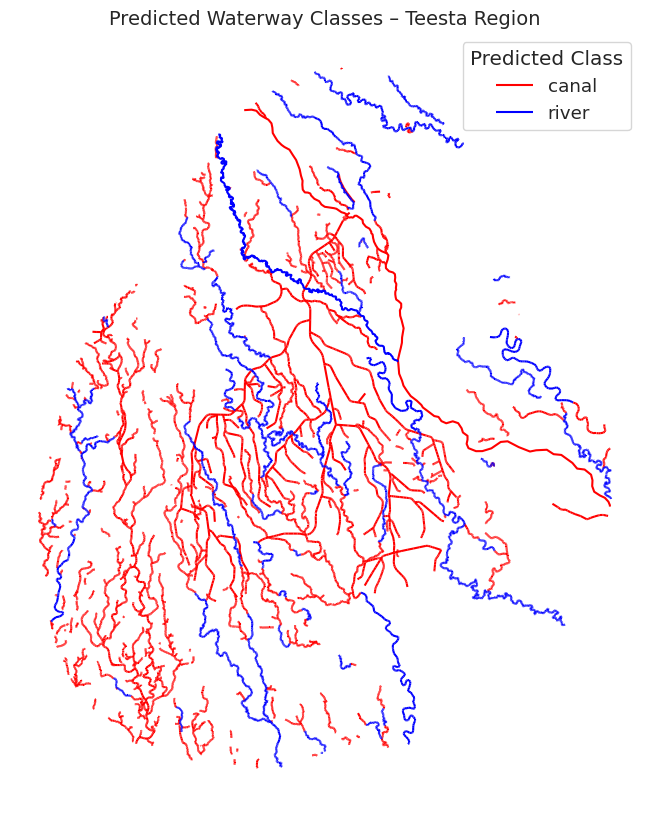

In [175]:
# Define custom colors for classes
colors = {
    "canal": "red",
    "river": "blue",
    # "Stream": "green"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
for label, color in colors.items():
    teesta_gdf[teesta_gdf["predicted_class"] == label].plot(
        ax=ax, color=color, linewidth=1.5, label=label
    )

plt.title("Predicted Waterway Classes – Teesta Region", fontsize=14)
plt.legend(title="Predicted Class")
plt.axis("off")
plt.show()


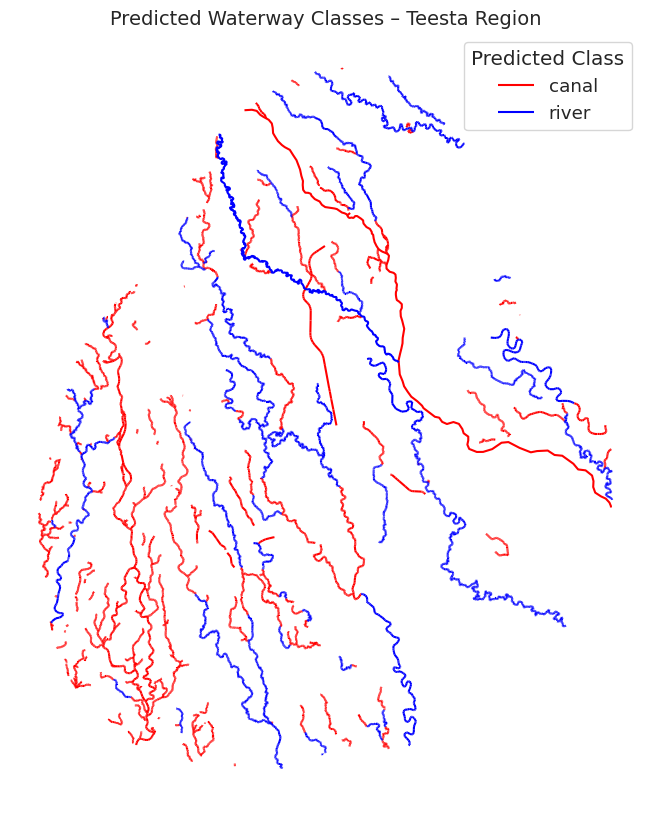

In [181]:
# Define custom colors for classes
colors = {
    "canal": "red",
    "river": "blue",
    # "Stream": "green"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
for label, color in colors.items():
    teesta_gdf_rivers[teesta_gdf_rivers["predicted_class"] == label].plot(
        ax=ax, color=color, linewidth=1.5, label=label
    )

plt.title("Predicted Waterway Classes – Teesta Region", fontsize=14)
plt.legend(title="Predicted Class")
plt.axis("off")
plt.show()
